## Google Drive

In [ ]:
DRIVE_MOUNT_PATH = '/content/drive'
BASE_DIR = DRIVE_MOUNT_PATH + "/MyDrive"
DATASET_PATH = BASE_DIR + "/data/elongated_word_10k.csv"
MODELS_DIR = BASE_DIR + "/indobert/models"

In [ ]:
from google.colab import drive
drive.mount(DRIVE_MOUNT_PATH)

Mounted at /content/drive


## Dependencies

In [ ]:
!pip install git+https://github.com/huggingface/transformers datasets

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-2f8g0w4n
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-2f8g0w4n
  Resolved https://github.com/huggingface/transformers to commit b54109c7466f6e680156fbd30fa929e2e222d730
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:

In [ ]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import datasets
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, create_optimizer

## Settings

In [ ]:
BATCH_SIZE = 32
MODEL_ID = "indolem/indobert-base-uncased"
TOKEN_MAX_LENGTH = 128
NUM_EPOCHS = 3

## Dataset preparation

### Load

In [ ]:
df_try = pd.read_csv(DATASET_PATH)
df_try['tokens'].describe()

,tokens
count,10000.000000
mean,161.966000
std,170.946713
min,5.000000
25%,34.000000
50%,112.000000
75%,249.000000
max,3478.000000


In [ ]:
df = pd.read_csv(DATASET_PATH)
df = df[:10000]
df.drop(columns=["tokens"], inplace=True)
df.rename(columns={"news": "text", "is_fake": "label"}, inplace=True)
print(df)

# Train-test split

train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

                                                   text  label
0     covid <NUMBER> subvarian xb berbeda  mematikan...      1
1     video salat berbahasa indonesia kursus salat d...      1
2     warga bogor meninggal hidup kembali    ajaib  ...      1
3     ikan alien aneh dijumpai di sungai madeira  br...      1
4     foto foto pemberontakan ulama dan santri di ma...      1
...                                                 ...    ...
9995  dicari  partai partai  pemersatu  bangsa endor...      0
9996  ksal yudo akui siap jalani fit and proper test...      0
9997  veronica koman dan data tahanan politik papua ...      0
9998  p ungkap kader ingin usung anies di pilpres <N...      0
9999  ngabalin sentil komitmen kepala daerah terkait...      0

[10000 rows x 2 columns]


In [ ]:
# Convert to Hugging Face Dataset
train_dataset = datasets.Dataset.from_dict(train_df)
test_dataset = datasets.Dataset.from_dict(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Tokenize

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=TOKEN_MAX_LENGTH)

tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
total_tokens = sum(len(example['input_ids']) for example in tokenized_dataset['train'])
avg_tokens = total_tokens / len(tokenized_dataset['train'])
print(f"Average number of tokens: {avg_tokens:.2f}")

Average number of tokens: 128.00


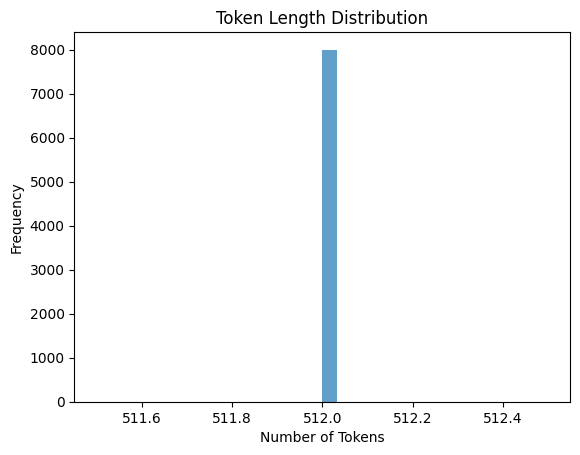

In [ ]:
import matplotlib.pyplot as plt

# Collect token lengths
token_lengths = [len(example['input_ids']) for example in tokenized_dataset['train']]

# Plot the distribution
plt.hist(token_lengths, bins=30, alpha=0.7)
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.show()

### Convert to Tensorflow format

In [ ]:
# Train Dataset
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    label_cols='label'
)

# Test Dataset
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    label_cols='label'
)

## Model

### Setup

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=1,
    from_pt=True
)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110558208 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 110558977 (421.75 MB)
Trainable params: 110558977 (421.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * NUM_EPOCHS)

# Optimizer
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=total_train_steps
  )

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

### Train

In [ ]:
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=5
)

Epoch 1/5
500/500 [==============================] - 333s 462ms/step - loss: 0.5775 - accuracy: 0.8605 - val_loss: 4.0303 - val_accuracy: 0.5725
Epoch 2/5
500/500 [==============================] - 225s 449ms/step - loss: 0.3914 - accuracy: 0.9280 - val_loss: 0.3655 - val_accuracy: 0.9420
Epoch 3/5
500/500 [==============================] - 222s 444ms/step - loss: 0.2904 - accuracy: 0.9477 - val_loss: 0.3513 - val_accuracy: 0.9445
Epoch 4/5
500/500 [==============================] - 222s 445ms/step - loss: 0.2543 - accuracy: 0.9541 - val_loss: 0.3513 - val_accuracy: 0.9445
Epoch 5/5
500/500 [==============================] - 222s 444ms/step - loss: 0.2515 - accuracy: 0.9560 - val_loss: 0.3513 - val_accuracy: 0.9445


### Save

In [ ]:
prefix = "indobert_"
timestr = time.strftime("%Y%m%d-%H%M%S")
ext = ".keras"

filename = prefix + timestr + ext
model.save(MODELS_DIR + "/" + filename)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


### Plot

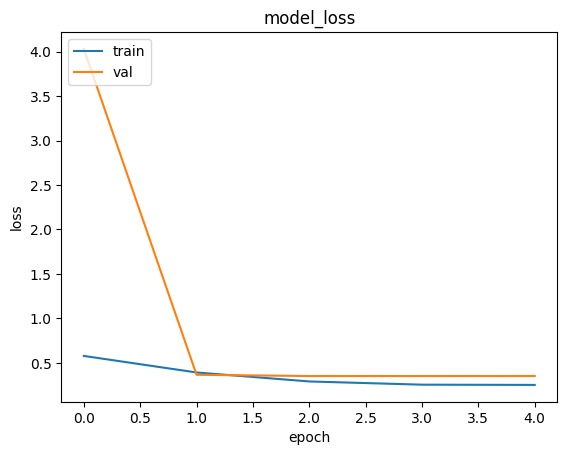

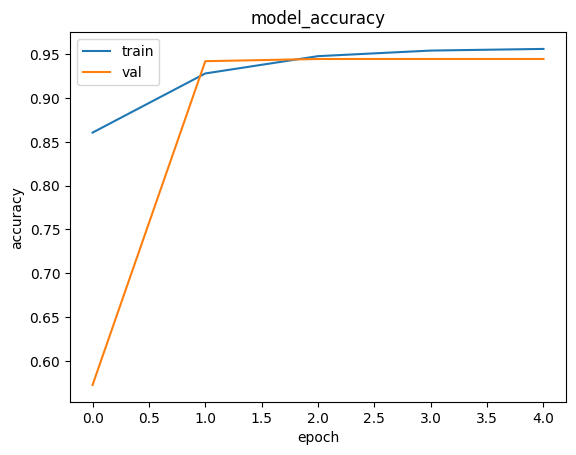

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Demo

In [ ]:
input_texts = [
    "Jokowi maju jadi presiden ketiga kali",
    "Makan nasi bisa tambah gemuk?",
    "Korps Garda Revolusi Islam Iran (IRGC) mengumumkan bahwa jenazah wakil komandan pasukan elit, Brigadir Jenderal Abbas Nilforoushan, telah ditemukan di Beirut, Lebanon. Nilforoushan tewas dalam serangan Israel di Beirut, Lebanon, pada 27 September lalu yang juga menewaskan pemimpin Hizbullah, Hassan Nasrallah."
]
inputs = tokenizer(input_texts, padding=True,return_tensors="tf")
logits = model(**inputs).logits
print(logits)

# Apply softmax to logits to get probabilities
probabilities = tf.nn.softmax(logits, axis=-1)
# Print the probabilities
print(probabilities)

tf.Tensor(
[[0.80415523]
 [0.73283345]
 [0.2591073 ]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[1.]
 [1.]
 [1.]], shape=(3, 1), dtype=float32)
